In [7]:
import pandas as pd
import torch as tc
import numpy as np
import multiprocessing
import re
from panoramix.panoramix.decompiler import decompile_bytecode
from transformers import DistilBertTokenizerFast
import torch
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments


ModuleNotFoundError: No module named 'timeout_decorator'

In [3]:
import web3
from web3 import Web3


def soft_decompile(byte_code):
    try:
        decompiled_code = decompile_bytecode(byte_code).text
        assert len(decompiled_code) > 200
        return decompiled_code
    except:
        try:
            byte_code = '0x' + byte_code[66:]
            decompiled_code = decompile_bytecode(byte_code).text
            assert len(decompiled_code) > 200
            return decompiled_code
        except:
            return "error"


def force_web3_code_decompile(contract_address):
    print("load from web3...")
    web3 = Web3(Web3.HTTPProvider("https://eth-mainnet.gateway.pokt.network/v1/lb/6266d6cdaa777e00391e0d29"))
    contract_bytecode = web3.eth.getCode(Web3.toChecksumAddress(contract_address))
    contract_bytecode_string = contract_bytecode.hex()
    decompiled_code = decompile_bytecode(contract_bytecode_string).text
    return decompiled_code

def simple_web3_code_decompile(byte_code):
    try:
        return decompile_bytecode(byte_code).text
    except:
        return "error"


def preprocess_code(code_str):
    code_str = code_str.replace("\n\n", "\n")
    lines = code_str.split('\n')

    # for line in lines:
    #     print(line)

    code_block = False
    for i, line in enumerate(lines):

        lines[i] += " ;"
        line += " ;"
        if line[:2] == "  " and not code_block:
            code_block = True
            lines[i] = line[2:]
            lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
            lines[i - 1] = lines[i - 1].replace(': ;', ' {')
        elif line[:2] == "  " and code_block:
            lines[i] = line[2:]
        elif line[:2] != "  " and code_block:
            code_block = False
            lines[i - 1] = lines[i - 1] + ' }'

        lines[i] = lines[i].replace('(', ' ( ')
        lines[i] = lines[i].replace(')', ' )')
        lines[i] = lines[i].replace('[', ' [ ')
        lines[i] = lines[i].replace(']', ' ]')
        lines[i] = lines[i].replace('.', ' . ')
        lines[i] = lines[i].replace('=', ' = ')

    code_block = False

    blocks_truncated = False
    while not blocks_truncated:
        blocks_truncated = True
        for i, line in enumerate(lines):
            if line[:2] == "  " and not code_block:
                code_block = True
                blocks_truncated = False
                lines[i] = line[2:]
                lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
                lines[i - 1] = lines[i - 1].replace(': ;', ' {')
            elif line[:2] == "  " and code_block:
                lines[i] = line[2:]
            elif line[:2] != "  " and code_block:
                code_block = False
                lines[i - 1] = lines[i - 1] + ' }'

    blocks_truncated = False
    while not blocks_truncated:
        blocks_truncated = True
        for i, line in enumerate(lines):
            if line[:2] == " " and not code_block:
                code_block = True
                blocks_truncated = False
                lines[i] = line[2:]
                lines[i - 1] = lines[i - 1].replace(':  ;', ' {')
                lines[i - 1] = lines[i - 1].replace(': ;', ' {')
            elif line[:2] == " " and code_block:
                lines[i] = line[2:]
            elif line[:2] != " " and code_block:
                code_block = False
                lines[i - 1] = lines[i - 1] + ' }'

    for i, line in enumerate(lines):
        lines[i] = line.replace("  ", " ")
    # for line in lines:
    #     print(line)

    joined =  " ".join(lines)
    pattern_code = r"0x[A-Fa-f0-9]{41,}\s"
    pattern_address = r"0x[A-Fa-f0-9]{40}\s"
    result = re.sub(pattern_code, "CODE", joined)
    result = re.sub(pattern_address, "ADDRESS", result)

    return result

global count
count = 0
def timeout_handler(signum, frame):
    raise TimeoutError("Timed out!")

def decompile_and_preprocess_row_target(bytecode_from_web3, creation_bytecode, return_dict):
    try:

        # if count % 10 == 0:
        #     print(count)

        if bytecode_from_web3 == '0x':
            return_dict['result'] = preprocess_code(soft_decompile(creation_bytecode))
        else:
            return_dict['result'] = preprocess_code(simple_web3_code_decompile(bytecode_from_web3))
    except:
        return_dict['result'] = "error"


def decompile_and_preprocess_row(bytecode_from_web3, creation_bytecode, malicious):
    if malicious == 0:
        manager = multiprocessing.Manager()
        return_dict = manager.dict()

        p = multiprocessing.Process(target=decompile_and_preprocess_row_target, args=(bytecode_from_web3, creation_bytecode, return_dict))
        p.start()
        p.join(60)
        if p.is_alive():
            print("running... let's kill it...")
            p.terminate()
            p.join()
            return "error"
        else:
            return return_dict['result']
    elif malicious == 1:
        return_dict = {}
        decompile_and_preprocess_row_target(bytecode_from_web3, creation_bytecode, return_dict)
        return return_dict['result']
    else:
        return "error"



In [5]:
normal_with_code_df = pd.read_csv('/home/venglov/Documents/normal_with_code.csv')
malicious_with_code_df = pd.read_csv('/home/venglov/Documents/malicious_with_code.csv')
sc_df = pd.concat([normal_with_code_df, malicious_with_code_df]).reset_index(drop=True)

In [7]:
sc_df = sc_df[:3141]
sc_df = sc_df.drop(sc_df[sc_df.decompiled_code == "error"].index)
sc_df = sc_df.drop(sc_df[sc_df.decompiled_code == "error ;"].index)
sc_df = sc_df.reset_index()
sc_df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,contract_address,contract_name,contract_etherscan_label,contract_tag,contract_creator,contract_creation_tx,...,malicious,contract_creator_tag,source,notes,contract_creator_etherscan_label,__index_level_0__,_lua_timestamp,_lua_uuid,bytecode_from_web3,decompiled_code
0,0,16804,16804,16804,0xb9feb10ec48f1377e3232504c8d55d8b829e7925,ASC,NaN,NaN,0x6ace97b861e902ce9076d6de027c372862f9d122,0x4246c9aef0d1a0a13bd870292940eb06737529383cf5...,...,0,NaN,NaN,NaN,NaN,56743,2022-12-05T20:18:10,bdbf408d-2097-47bd-846e-5af7a8db454c,0x608060405260043610610099576000357c0100000000...,def storage { balanceOf is mapping of uint256 ...
1,1,15728,15728,15728,0xc9830b80b9a8d88a30919cda303b2cef9b7e7ab3,HumanStandardToken,NaN,NaN,0x8063b2b7374dd4a24d6324fbabebfdfc5d7868bc,0x113b447dfe61c19fe0c8eafd86806aa683c4c25f9a2d...,...,0,NaN,NaN,NaN,NaN,119161,2022-12-05T20:18:10,df4700a2-befe-4921-8409-bc28bb58d148,0x6060604052361561008d5760e060020a600035046306...,def storage { balanceOf is mapping of uint256 ...
2,2,6017,6017,6017,0x2f1817f25d95f03355fdc5f55d91aec7bc94db43,Forwarder,NaN,NaN,0x00bdb5699745f5b860228c8f939abf1b9ae374ed,0x3520c3e2252bf6c2c4e421e9a00ec43b17dd4a1944ee...,...,0,NaN,NaN,NaN,NaN,105643,2022-12-05T20:18:10,db408986-a069-4e14-8318-07a783d0bfb7,0x6060604052361561003a5763ffffffff60e060020a60...,def storage { parentAddress is addr at storage...
3,3,27433,27433,27433,0x767820dd0636ea9fa6b26a5be71b93b9f5ed79eb,BPool,NaN,NaN,0xd3ec472688fe68c3398fa4ead35b4d97e63031bc,0x3fc842f9c19e8bfde3c25b938372be52372a67f1cfde...,...,0,NaN,NaN,NaN,NaN,99616,2022-12-05T20:18:10,3ecf7999-027c-4649-8e3a-133028e71f97,0x363d3d373d3d3d363d73ee8ac082aeb41b0f5a41aae8...,def _fallback ( ) payable { delegate ADDRESSwi...
4,4,28213,28213,28213,0x1e8bbde11dfef31532c78260502ae0a629f58e39,CEtherDelegator,NaN,NaN,0x6ce798bc8c8c93f3c312644dcbdd2ad6698622c5,0x23e434e7fe104c070faf16e10ad8de42a44afe739709...,...,0,NaN,NaN,NaN,NaN,87448,2022-12-05T20:18:10,4feeea4d-3c3a-42e4-8fb8-4c3f3586df73,0x6080604052600436106100555760003560e01c806309...,def storage { implementationAddress is addr at...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,136,136,136,136,0x10c509aa9ab291c76c45414e7cdbd375e1d5ace8,NaN,NaN,NaN,0x8efab89b497b887cdaa2fb08ff71e4b3827774b2,0xbe65cb0dd9f4619939cfeb56b3ef3a996e2b028b93fd...,...,1,Visor Finance Exploiter,Luabase ethereum.tags table,NaN,heist,74,2022-12-05T20:18:10,cd25dc25-4a41-44cc-b936-9c88805d1e25,0x608060405234801561001057600080fd5b5060043610...,def storage { owner is addr at storage 0 ; poo...
3137,137,137,137,137,0xdba351f902c8cd525329e2d38b0e1e8343a0d7b5,NaN,NaN,NaN,0x941a9e3b91e1cc015702b897c512d265fae88a9c,0x7f777a94444ff4c85b00698e918e5b340afdd6d6ae95...,...,1,ChainSwap Exploiter,Luabase ethereum.tags table,NaN,exploit,79,2022-12-05T20:18:10,b0ce3a52-7134-452a-bc61-43d92c599994,0x608060405234801561001057600080fd5b5060043610...,def storage { owner is addr at storage 0 ; } d...
3138,138,138,138,138,0x54b5ae5ebe86d2d86134f3bb7e36e7c83295cbcb,NaN,NaN,BT.Finance Exploiter,0x358abccb4f5bb715482271890929fdabb3015878,0xf792f288e0e23e0d65136de3f309572e29890735586c...,...,1,NaN,Luabase ethereum.tags table,NaN,NaN,19,2022-12-05T20:18:10,45427982-d406-44ee-ba8d-c3dbdf3418d9,0x,def storage { stor0 is addr at storage 0 ; sto...
3139,139,139,139,139,0xf52045f26afece501048e132e5c9544c0b6ece94,NaN,NaN,NaN,0x8b4c1083cd6aef062298e1fa900df9832c8351b3,0x39982143e4c82fc1686948b4ccc50135256329b105f9...,...,1,Inverse Finance Exploiter 2,Luabase ethereum.tags table,NaN,exploit,66,2022-12-05T20:18:10,700d78a5-c3a8-49c7-bcae-8ee968bc27a9,0x60806040526004361061007f5760003560e01c806349...,def storage { stor0 is uint256 at storage 0 ; ...


In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [10]:
inputs = tokenizer(sc_df.decompiled_code.tolist(), padding="max_length", truncation=True)

In [11]:
class SmartContractsDataset(tc.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # self.sc_df = sc_df
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # code = self.sc_df.decompiled_code[idx]
        # code = simple_web3_code_decompile(code)
        # code = preprocess_code(code)
        # code = self.get_contract_as_image(code).transpose(2, 0, 1)
        # code = tc.tensor(code).type(tc.float32)
        # code = tokenizer(code).items()

        # mal = self.sc_df.malicious[idx]
        # mal = tc.tensor(mal).type(tc.float32)
        # return code, mal

        # item = {key: torch.tensor(val[idx]) for key, val in code}
        # item['label'] = mal
        # return item
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item


In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [14]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [15]:
scd = SmartContractsDataset(inputs, sc_df.malicious.tolist())
train_size = int(0.8 * len(scd))
val_size = int(0.1 * len(scd))
test_size = len(scd) - train_size - val_size
training_dataset, validation_dataset, testing_dataset = tc.utils.data.random_split(scd,
                                                                                   [train_size, val_size, test_size])


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=validation_dataset,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [18]:
trainer.train()

/home/venglov/.venv/torch_gpu/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2070
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2600
  Number of trainable parameters = 66955010


Step,Training Loss


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2600, training_loss=0.03126139126640807, metrics={'train_runtime': 463.7623, 'train_samples_per_second': 89.27, 'train_steps_per_second': 5.606, 'total_flos': 5484150304358400.0, 'train_loss': 0.03126139126640807, 'epoch': 20.0})

In [19]:
results = []
for i in range(len(testing_dataset)):
    code = testing_dataset[i]
    label = code['label']
    input_ids = torch.tensor(code["input_ids"]).to(device)
    attention_mask = torch.tensor(code["attention_mask"]).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())
    results.append((label, y))

/tmp/ipykernel_1000348/1724829149.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(code["input_ids"]).to(device)
/tmp/ipykernel_1000348/1724829149.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(code["attention_mask"]).to(device)


In [20]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

# Generates count of inference quadrants
for real, predicted in results:
    if real == 1 and predicted == 1:
        true_positive += 1
    elif real == 0 and predicted == 0:
        true_negative += 1
    elif real == 1 and predicted == 0:
        false_negative += 1
    elif real == 0 and predicted == 1:
        false_positive += 1

# print(l2)
print("True Positive:", true_positive)
print("True Negative:", true_negative)
print("False Positive:", false_positive)
print("False Negative:", false_negative)

# Machine Learning statistics and visuals. https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
print("Accuracy:", (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative))
precision = true_positive/(true_positive + false_positive)
print("Precision:", precision)
recall = true_positive/(true_positive + false_negative)
print("Recall:", recall)
print("F1-score", 2*(recall * precision)/(recall + precision))
print("Specificity:", true_negative/(true_negative + false_positive))

True Positive: 14
True Negative: 244
False Positive: 0
False Negative: 2
Accuracy: 0.9923076923076923
Precision: 1.0
Recall: 0.875
F1-score 0.9333333333333333
Specificity: 1.0


In [77]:
results

[(tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(1), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 1),
 (tensor(0), 0),
 (tensor(0), 0),
 (tensor(0), 0

<AxesSubplot: >

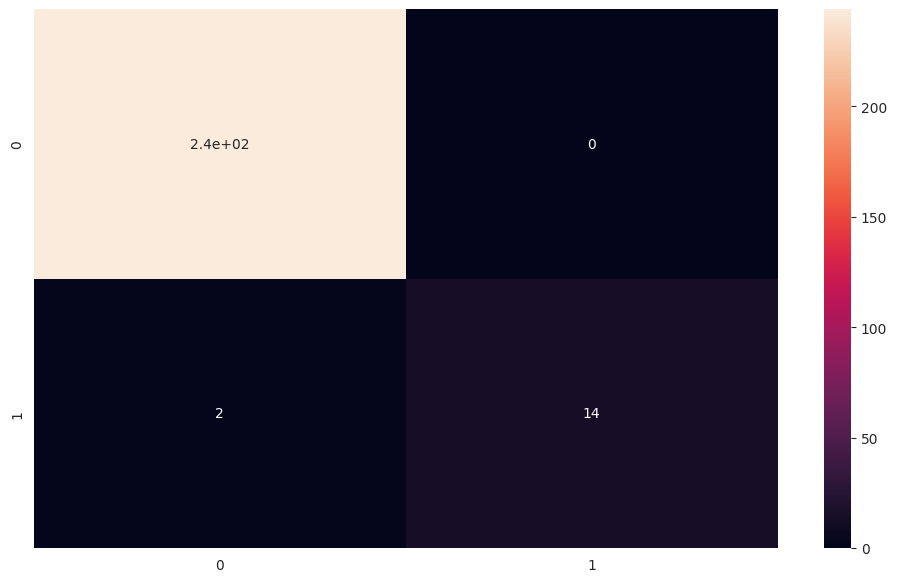

In [21]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
real = []
predicted = []
for r, p in results:
    real.append(r)
    predicted.append(p)
cf_matrix = confusion_matrix(real, predicted)
df_cm = pd.DataFrame(cf_matrix, index=[0, 1],
                     columns=[0, 1])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)

In [22]:
torch.save(model.state_dict(), '/home/venglov/Documents/model_weights.pth')

In [23]:
model.load_state_dict(torch.load("/home/venglov/Documents/model_weights.pth"))

<All keys matched successfully>

In [24]:
address = "0x792e8f3727cad6e00c58d478798f0907c4cec340"


In [25]:
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [26]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [27]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


loading file vocab.txt from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /home/venglov/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropo

In [15]:
web3 = Web3(Web3.HTTPProvider("https://eth-mainnet.gateway.pokt.network/v1/lb/6266d6cdaa777e00391e0d29"))
code = web3.eth.getCode(Web3.toChecksumAddress(address))

In [3]:
code = "0x6000602061034003526102006112e0602039600051803560f81c906001016000526002026020015160f01c565b5b00600051803560f81c906001016000526002026020015160f01c565b01600051803560f81c906001016000526002026020015160f01c565b02600051803560f81c906001016000526002026020015160f01c565b03600051803560f81c906001016000526002026020015160f01c565b04600051803560f81c906001016000526002026020015160f01c565b05600051803560f81c906001016000526002026020015160f01c565b06600051803560f81c906001016000526002026020015160f01c565b07600051803560f81c906001016000526002026020015160f01c565b08600051803560f81c906001016000526002026020015160f01c565b09600051803560f81c906001016000526002026020015160f01c565b0a600051803560f81c906001016000526002026020015160f01c565b0b600051803560f81c906001016000526002026020015160f01c565b10600051803560f81c906001016000526002026020015160f01c565b11600051803560f81c906001016000526002026020015160f01c565b12600051803560f81c906001016000526002026020015160f01c565b13600051803560f81c906001016000526002026020015160f01c565b14600051803560f81c906001016000526002026020015160f01c565b15600051803560f81c906001016000526002026020015160f01c565b16600051803560f81c906001016000526002026020015160f01c565b17600051803560f81c906001016000526002026020015160f01c565b18600051803560f81c906001016000526002026020015160f01c565b19600051803560f81c906001016000526002026020015160f01c565b1a600051803560f81c906001016000526002026020015160f01c565b1b600051803560f81c906001016000526002026020015160f01c565b1c600051803560f81c906001016000526002026020015160f01c565b1d600051803560f81c906001016000526002026020015160f01c565b6103400120600051803560f81c906001016000526002026020015160f01c565b30600051803560f81c906001016000526002026020015160f01c565b31600051803560f81c906001016000526002026020015160f01c565b32600051803560f81c906001016000526002026020015160f01c565b33600051803560f81c906001016000526002026020015160f01c565b34600051803560f81c906001016000526002026020015160f01c565b506000600051803560f81c906001016000526002026020015160f01c565b6000600051803560f81c906001016000526002026020015160f01c565b610340019050369037600051803560f81c906001016000526002026020015160f01c565b36600051803560f81c906001016000526002026020015160f01c565b6103400137600051803560f81c906001016000526002026020015160f01c565b3a600051803560f81c906001016000526002026020015160f01c565b3b600051803560f81c906001016000526002026020015160f01c565b9061034001903c600051803560f81c906001016000526002026020015160f01c565b3d600051803560f81c906001016000526002026020015160f01c565b610340013e600051803560f81c906001016000526002026020015160f01c565b3f600051803560f81c906001016000526002026020015160f01c565b40600051803560f81c906001016000526002026020015160f01c565b41600051803560f81c906001016000526002026020015160f01c565b42600051803560f81c906001016000526002026020015160f01c565b43600051803560f81c906001016000526002026020015160f01c565b44600051803560f81c906001016000526002026020015160f01c565b45600051803560f81c906001016000526002026020015160f01c565b46600051803560f81c906001016000526002026020015160f01c565b47600051803560f81c906001016000526002026020015160f01c565b48600051803560f81c906001016000526002026020015160f01c565b50600051803560f81c906001016000526002026020015160f01c565b6103400151600051803560f81c906001016000526002026020015160f01c565b6103400152600051803560f81c906001016000526002026020015160f01c565b6103400153600051803560f81c906001016000526002026020015160f01c565b54600051803560f81c906001016000526002026020015160f01c565b55600051803560f81c906001016000526002026020015160f01c565b803560f81c90600101600052605b14156106dd57600051803560f81c906001016000526002026020015160f01c565b60006000fd5b906106ae5750600051803560f81c906001016000526002026020015160f01c565b600160005103600051803560f81c906001016000526002026020015160f01c565b6000610340015903600051803560f81c906001016000526002026020015160f01c565b5a600051803560f81c906001016000526002026020015160f01c565b600051803560f81c906001016000526002026020015160f01c565b60016000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60026000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60036000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60046000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60056000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60066000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60076000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60086000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60096000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600a6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600b6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600c6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600d6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600e6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b600f6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60106000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60116000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60126000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60136000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60146000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60156000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60166000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60176000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60186000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60196000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601a6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601b6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601c6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601d6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601e6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b601f6000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b60206000518035826020036008021c9101600052600051803560f81c906001016000526002026020015160f01c565b80600051803560f81c906001016000526002026020015160f01c565b81600051803560f81c906001016000526002026020015160f01c565b82600051803560f81c906001016000526002026020015160f01c565b83600051803560f81c906001016000526002026020015160f01c565b84600051803560f81c906001016000526002026020015160f01c565b85600051803560f81c906001016000526002026020015160f01c565b86600051803560f81c906001016000526002026020015160f01c565b87600051803560f81c906001016000526002026020015160f01c565b88600051803560f81c906001016000526002026020015160f01c565b89600051803560f81c906001016000526002026020015160f01c565b8a600051803560f81c906001016000526002026020015160f01c565b8b600051803560f81c906001016000526002026020015160f01c565b8c600051803560f81c906001016000526002026020015160f01c565b8d600051803560f81c906001016000526002026020015160f01c565b8e600051803560f81c906001016000526002026020015160f01c565b8f600051803560f81c906001016000526002026020015160f01c565b90600051803560f81c906001016000526002026020015160f01c565b91600051803560f81c906001016000526002026020015160f01c565b92600051803560f81c906001016000526002026020015160f01c565b93600051803560f81c906001016000526002026020015160f01c565b94600051803560f81c906001016000526002026020015160f01c565b95600051803560f81c906001016000526002026020015160f01c565b96600051803560f81c906001016000526002026020015160f01c565b97600051803560f81c906001016000526002026020015160f01c565b98600051803560f81c906001016000526002026020015160f01c565b99600051803560f81c906001016000526002026020015160f01c565b9a600051803560f81c906001016000526002026020015160f01c565b9b600051803560f81c906001016000526002026020015160f01c565b9c600051803560f81c906001016000526002026020015160f01c565b9d600051803560f81c906001016000526002026020015160f01c565b9e600051803560f81c906001016000526002026020015160f01c565b9f600051803560f81c906001016000526002026020015160f01c565b61034001a0600051803560f81c906001016000526002026020015160f01c565b61034001a1600051803560f81c906001016000526002026020015160f01c565b61034001a2600051803560f81c906001016000526002026020015160f01c565b61034001a3600051803560f81c906001016000526002026020015160f01c565b61034001a4600051803560f81c906001016000526002026020015160f01c565b906103400190f0600051803560f81c906001016000526002026020015160f01c565b926103400192946103400194f1600051803560f81c906001016000526002026020015160f01c565b926103400192946103400194f2600051803560f81c906001016000526002026020015160f01c565b61034001f35b6020803803610220396102205173ffffffffffffffffffffffffffffffffffffffff16301461124857916103400191936103400193f4600051803560f81c906001016000526002026020015160f01c565b60006000fd5b906103400190f5600051803560f81c906001016000526002026020015160f01c565b916103400191936103400193fa600051803560f81c906001016000526002026020015160f01c565b61034001fd600051803560f81c906001016000526002026020015160f01c565bfe600051803560f81c906001016000526002026020015160f01c565b60006000fd5b60006000fd002d004900650081009d00b900d500f1010d01290145016112da12da12da12da017d019901b501d101ed020902250241025d0279029502b102cd02e912da12da030512da12da12da12da12da12da12da12da12da12da12da12da12da12da12da03250341035d0379039503b103cf03ec0410042c044c0468048404a604c204e204fe051a05360552056e058a05a605c205de12da12da12da12da12da12da12da05fa0616063606560676069206ae06e3070407250748076412da12da12da12da077f07ae07dd080c083b086a089908c808f709260955098409b309e20a110a400a6f0a9e0acd0afc0b2b0b5a0b890bb80be70c160c450c740ca30cd20d010d300d5f0d7b0d970db30dcf0deb0e070e230e3f0e5b0e770e930eaf0ecb0ee70f030f1f0f3b0f570f730f8f0fab0fc70fe30fff101b10371053106f108b10a710c310df10ff111f113f115f12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da12da117f11a111c911f111f7124e12da12da12da12da127012da12da129812b812d4000000000000000000000000cb70efa43300cd9b7ef4ed2087cea7f7f6f3c195"

In [5]:
opcodes = disassemble_hex(code)

NameError: name 'disassemble_hex' is not defined

In [5]:

opcodes

"def _fallback ( ) payable {  . . .  # Decompilation aborted, sorry: ( 'jump to a parameter computed at runtime', 0 ) ; }  ;"

In [83]:
inputs = tokenizer([decompiled], padding="max_length", truncation=True)


In [84]:
item = {key: torch.tensor(val[0]) for key, val in inputs.items()}

In [85]:
input_ids = torch.tensor(item["input_ids"]).to(device)
attention_mask = torch.tensor(item["attention_mask"]).to(device)
with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
y = np.argmax(outputs[0].to('cpu').numpy())

/tmp/ipykernel_1000348/3075049496.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(item["input_ids"]).to(device)
/tmp/ipykernel_1000348/3075049496.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(item["attention_mask"]).to(device)


In [86]:
outputs[0]

tensor([[ 4.8980, -4.9567]], device='cuda:0')

In [87]:
y

0